#### Import libraries and define timer

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.sparse import csr_matrix
from prepper6 import clean, timer, click_book_rates
from sklearn.metrics import ndcg_score
import timeit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tables

#### Loading data via csv or prepper function (choose)

In [2]:
# #DEZE STAAT ER ALLEEN FF ALS IK GEEN IZN HEB OM DIE PREPROCESS OPNIEUW TE DOEN
# #Load data
# start_time = timer()
# path = '/Users/jorrimprins/Google Drive/MSc Econometrics/Data Mining Techniques/Assignment 2/Scripts/'
# df_train = pd.read_csv(path+'df_train.csv')#,header=None, engine='python')
# timer(start_time)
# df_test = pd.read_csv(path+'df_test.csv')
# timer(start_time)

Time taken: 0 hours 1 minutes and 35.38 seconds.
Time taken: 0 hours 3 minutes and 3.51 seconds.


In [7]:
#Load data from csv
path = '/Users/jorrimprins/Google Drive/MSc Econometrics/Data Mining Techniques/Assignment 2/Data/'
start_time = timer()
print('Reading data from csv...')
df_test_base = pd.read_csv(path+'test_set_VU_DM.csv')
timer(start_time)
df_training_base = pd.read_csv(path+'training_set_VU_DM.csv')
timer(start_time)

Reading data from csv...
Time taken: 0 hours 0 minutes and 23.41 seconds.
Time taken: 0 hours 0 minutes and 53.13 seconds.


In [8]:
#Clean data
start_time = timer()
df_test = clean(df_test_base)
timer(start_time)
df_train = clean(df_training_base)
timer(start_time)

#Create click_boot_rates and add
start_time = timer()
df_rates = click_book_rates(df_training_base)
df_test = pd.merge(df_test,df_rates,on='prop_id',how='left')
df_train = pd.merge(df_train,df_rates,on='prop_id',how='left')
timer(start_time)

Okay, we're cleaning the test set boys.

Convert date time column
Fill NaN's with zeros or averages
Fill NaN's for competitors with zeros
Time taken: 0 hours 0 minutes and 3.83 seconds.
Start feature extraction
Normalize wrt to site_id
Normalize wrt to prop_country_id
Normalize wrt to srch_destination_id
Normalize wrt to month
Normalize wrt to srch_length_of_stay
Adding mean, median and std of:  prop_starrating
Adding mean, median and std of:  prop_review_score
Adding mean, median and std of:  log_price_usd
Adding mean, median and std of:  prop_log_historical_price
Adding mean, median and std of:  prop_location_score1
Time taken: 0 hours 3 minutes and 58.72 seconds.
Concatenating site normalizations
Concatenating prop_country normalizations
Concatenating srch_destination normalizations
Concatenating month normalizations
Concatenating srch_length normalizations
Time taken: 0 hours 9 minutes and 52.63 seconds.
Time taken: 0 hours 9 minutes and 52.87 seconds.
Okay, we're cleaning the trai

In [21]:
# df_train.to_csv('df_train.csv',index=False)
# df_test.to_csv('df_test.csv',index=False)
#df_train.to_pickle('df_train.pkl')  # where to save it, usually as a .pkl
start_time = timer()
store = pd.HDFStore('store.h5')
store['df_train'] = df_train
timer(start_time)
store['df_test'] = df_test
timer(start_time)

Time taken: 0 hours 4 minutes and 2.36 seconds.
Time taken: 0 hours 7 minutes and 5.29 seconds.


#### Create PCA

In [9]:
#Dit stuk gebruiken we wss niet, misschien als het allemaal echt te lang duurt maar in principe 
#Doet XGBoost dit voor ons
# Maybe add 2 or 3 PCA's???
pcacols = df_train.columns.tolist()[73:120]
pca = PCA(n_components=10)
start_time = timer()
pca.fit(df_train.loc[:,pcacols])
pca_test = pca.transform(df_test.loc[:,pcacols])
timer(start_time)
pca_train = pca.transform(df_train.loc[:,pcacols])
timer(start_time)

pca_traindata = pd.DataFrame(pca_train,columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10'])
pca_testdata = pd.DataFrame(pca_test,columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10'])

                            
dropcols = df_train.columns.tolist()[15:24]+df_train.columns.tolist()[25:49]+pcacols
df_test.drop(columns=dropcols,axis=1,inplace=True)
timer(start_time)
df_train.drop(columns=dropcols,axis=1,inplace=True)
timer(start_time)
                            
df_test = pd.concat([df_test,pca_testdata],axis=1)
df_train = pd.concat([df_train,pca_traindata],axis=1)

Time taken: 0 hours 1 minutes and 49.05 seconds.
Time taken: 0 hours 2 minutes and 14.75 seconds.
Time taken: 0 hours 2 minutes and 21.8 seconds.
Time taken: 0 hours 2 minutes and 32.7 seconds.


#### Create target and sparse var matrix, groups vector and split validation and train set


In [10]:
#Group sizes vector
groups = np.array(df_train.srch_id.value_counts(sort=False).sort_index())
df_train = df_train.sort_values(by=['srch_id']).reset_index(drop=True)

start_time = timer()
#Determine training length and create train and val set
trainlength = sum(groups[0:149765])
y_train = df_train.score[0:trainlength]
y_val = df_train.score[trainlength:len(df_train)]
print('Y variables split')
X_train = csr_matrix(df_train.drop(['srch_id','score','click_bool','gross_bookings_usd',
                                    'booking_bool','position'],axis=1)[0:trainlength])
print('X_train made')
X_val = csr_matrix(df_train.drop(['srch_id','score','click_bool','gross_bookings_usd',
                                  'booking_bool','position'],axis=1)[trainlength:len(df_train)])
print('X_val made')
timer(start_time)

Y variables split
X_train made
X_val made
Time taken: 0 hours 0 minutes and 35.74 seconds.


#### Define and fit model with evaluation (duurt 10 min)

In [106]:
param_grid = {'max_depth': [4,5,6,7,8],
              'learning_rate': [0.2, 0.3, 0.4, 0.5],
              'reg_lambda': [0.1, 0.2, 0.3, 0.4],
              'objective': ['rank:ndcg'],
             'n_est': [100],
             'gamma': [0.5, 1, 1.5],
             'subsample': [0.8]}

In [12]:
param_grid = {'max_depth': [5],
              'learning_rate': [0.2],
              'reg_lambda': [0.2],
              'objective': ['rank:ndcg'],
             'n_est': [250],
             'gamma': [0],
             'subsample': [1]}

In [13]:
#Large sample voorbeeld
convergence = []
subsample = param_grid['subsample'][0]
ndcg_data = pd.DataFrame(columns=['obj','max_depth','learning_rate','lambda','gamma','n_estimators','stoplength','ndcg'])
for n in param_grid['n_est']:
    for obj in param_grid['objective']:
        for lam in param_grid['reg_lambda']:
            for eta in param_grid['learning_rate']:
                  for gam in param_grid['gamma']:
                        for depth in param_grid['max_depth']:
                            start_time = timer()
                            xgb_rank = xgb.XGBRanker(n_estimators=n,max_depth=depth,learning_rate=eta, objective=obj,
                                                     reg_lambda=lam,subsample=subsample,gamma=gam)
                            model = xgb_rank.fit(X_train,y_train,groups[0:149765],eval_set=[(X_val,y_val)],
                                             eval_group=[groups[149765:len(groups)].tolist()],eval_metric='ndcg',early_stopping_rounds=20)
                            ndcg = model.['eval_0']['ndcg'][-1]
                            convergence.append(model.evals_result['eval_0']['ndcg'])
                            stop = len(model.evals_result['eval_0']['ndcg'])
                            epoch_data = {'obj': obj,
                                          'max_depth': depth,
                                          'learning_rate': eta,
                                          'lambda': lam,
                                          'gamma': gam,
                                          'n_estimators': n,
                                          'stoplength': stop,
                                          'ndcg': ndcg}
                            ndcg_data = ndcg_data.append(epoch_data, ignore_index=True)
                            print(epoch_data)
                            timer(start_time)
                
ndcg_data = ndcg_data.sort_values(by='ndcg',ascending=False)
#ndcg_data.to_csv('model_eval.csv',index=False)
ndcg_data


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


{'obj': 'rank:ndcg', 'max_depth': 5, 'learning_rate': 0.2, 'lambda': 0.2, 'gamma': 0, 'n_estimators': 250, 'stoplength': 250, 'ndcg': 0.569641}
Time taken: 0 hours 28 minutes and 26.48 seconds.


,obj,max_depth,learning_rate,lambda,gamma,n_estimators,stoplength,ndcg
0,rank:ndcg,5,0.2,0.2,0,250,250,0.569641


In [107]:
#Small sample voorbeeld
convergence = []
subsample = param_grid['subsample'][0]
ndcg_data = pd.DataFrame(columns=['obj','max_depth','learning_rate','lambda','gamma','n_estimators','stoplength','ndcg'])
for n in param_grid['n_est']:
    for obj in param_grid['objective']:
        for lam in param_grid['reg_lambda']:
            for eta in param_grid['learning_rate']:
                for gam in param_grid['gamma']:
                    for depth in param_grid['max_depth']:
                        xgb_rank = xgb.XGBRanker(n_estimators=n,max_depth=depth,learning_rate=eta, objective=obj,reg_lambda=lam,
                                                subsample=subsample,gamma=gam)
                        model = xgb_rank.fit(X_train[0:2492],y_train[0:2492],groups[0:100],eval_set=[(X_val[0:2447],y_val[0:2447])],
                                         eval_group=[groups[149765:149865].tolist()],eval_metric='ndcg',early_stopping_rounds=20)
                        ndcg = model.evals_result['eval_0']['ndcg'][-1]
                        convergence.append(model.evals_result['eval_0']['ndcg'])
                        stop = len(model.evals_result['eval_0']['ndcg'])
                        epoch_data = {'obj': obj,
                                      'max_depth': depth,
                                      'learning_rate': eta,
                                      'lambda': lam,
                                      'gamma': gam,
                                      'n_estimators': n,
                                      'stoplength': stop,
                                      'ndcg': ndcg}
                        ndcg_data = ndcg_data.append(epoch_data, ignore_index=True)
ndcg_data.sort_values(by='ndcg',ascending=False)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,obj,max_depth,learning_rate,lambda,gamma,n_estimators,stoplength,ndcg
221,rank:ndcg,5,0.4,0.4,1.5,100,51,0.505258
25,rank:ndcg,4,0.3,0.1,1.5,100,80,0.502189
28,rank:ndcg,7,0.3,0.1,1.5,100,40,0.492054
103,rank:ndcg,7,0.4,0.2,1.5,100,42,0.490205
163,rank:ndcg,7,0.4,0.3,1.5,100,73,0.486494
216,rank:ndcg,5,0.4,0.4,1.0,100,21,0.484688
58,rank:ndcg,7,0.5,0.1,1.5,100,70,0.484485
215,rank:ndcg,4,0.4,0.4,1.0,100,22,0.484334
186,rank:ndcg,5,0.2,0.4,1.0,100,34,0.483336
40,rank:ndcg,4,0.4,0.1,1.5,100,61,0.482998


##### Make prediction and write to csv

In [15]:
srch_id_list = np.unique(df_test.srch_id)
preds = []
ids = []
props = []
start_time = timer()
#full_predictions = pd.DataFrame(columns=['ids','props','preds'])
for i in srch_id_list:
    if i % 10000 == 0:
        print(i,' queries done')
        timer(start_time)
    df_test_help = df_test.loc[df_test.srch_id==i]
    testvars = csr_matrix(df_test_help.drop(['srch_id'],axis=1))
    ids.extend(np.repeat(i,len(df_test_help)))
    predshelp = model.predict(testvars).tolist()
    propshelp = df_test_help['prop_id'].values.tolist()
    predshelp, propshelp = zip(*sorted(zip(predshelp,propshelp),reverse=True))
    props.extend(propshelp)
timer(start_time)
full_predictions = pd.DataFrame({'srch_id': ids,
                                'prop_id': props})
date = str(datetime.today().day)+'-'+str(datetime.today().month)
full_predictions.to_csv('predictions_500_lam0.3_eta0.5_4depth_1gamma'+date+'.csv',index=False)

full_predictions


10000  queries done
Time taken: 0 hours 0 minutes and 46.68 seconds.
30000  queries done
Time taken: 0 hours 2 minutes and 8.52 seconds.
60000  queries done
Time taken: 0 hours 4 minutes and 15.6 seconds.
80000  queries done
Time taken: 0 hours 5 minutes and 39.08 seconds.
130000  queries done
Time taken: 0 hours 9 minutes and 11.78 seconds.
150000  queries done
Time taken: 0 hours 10 minutes and 34.91 seconds.
160000  queries done
Time taken: 0 hours 11 minutes and 14.68 seconds.
180000  queries done
Time taken: 0 hours 12 minutes and 41.62 seconds.
190000  queries done
Time taken: 0 hours 13 minutes and 24.0 seconds.
200000  queries done
Time taken: 0 hours 14 minutes and 6.28 seconds.
210000  queries done
Time taken: 0 hours 14 minutes and 54.21 seconds.
220000  queries done
Time taken: 0 hours 15 minutes and 38.84 seconds.
270000  queries done
Time taken: 0 hours 19 minutes and 32.68 seconds.
280000  queries done
Time taken: 0 hours 20 minutes and 18.52 seconds.
290000  queries don

,srch_id,prop_id
0,1,99484
1,1,28181
2,1,54937
3,1,61934
4,1,50162
5,1,90385
6,1,5543
7,1,34263
8,1,24194
9,1,63894


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


[]


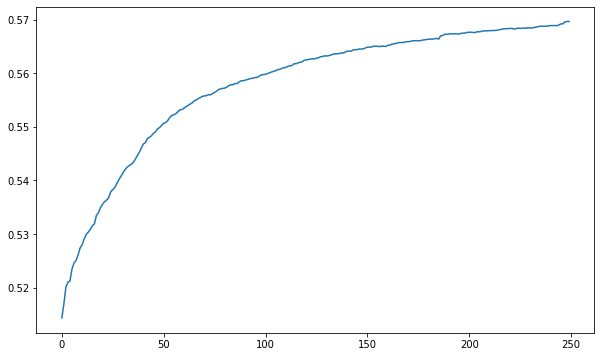

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))

axs.plot(range(len(convergence[0])), convergence[0])
fig.show()
print(model.feature_importances_[88:92])
df_train.columns[88:92]

fig.savefig('convergence_pca10.pdf',dpi=300,)


#important: click_rate'srch_children_count_wrt_srch_destination_id',srch_children_count_wrt_prop_country_id  
#mean_prop_location_score1 prop_log_historical_price prop_location_score1  